In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import numpy as np
import os
import functions as f
from glob import glob
from mpl_toolkits.basemap import Basemap
from numpy import meshgrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import itertools
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LatitudeLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, TwoSlopeNorm
import pandas as pd
import math
from datetime import datetime
import datetime as dt
import preprocessUtils as putils
import masks
import verifications



2024-02-15 06:39:35.905334: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-15 06:39:38.570748: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-15 06:39:56.109493: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook imp

In [ ]:
dir = '/glade/work/klesinger/FD_RZSM_deep_learning'

In [4]:
#Set script parameters
global region_name
region_name = 'CONUS' #['CONUS','australia']

mask = masks.load_mask(region_name)

if region_name == 'CONUS':
    region_mask = masks.load_region_mask(region_name).rename({'latitude':'lat','longitude':'lon'}).isel(time=0)
    CONUS_region_names = {1:'Northeast',2:'Southeast',3:'Midwest',4:'Great Plains',5:'Northwest',6:'Southwest'}

#Mask with np.nan for non-CONUS land values
mask_anom = mask[putils.xarray_varname(mask)][0,:,:].values



In [5]:


#Load observation anomaly as raw file
if region_name == 'CONUS':
    source = 'Data/GLEAM'
elif region_name == 'australia':
    source = 'Data_australia/GLEAM'

global obs_original
obs_original = xr.open_dataset(f'{source}/RZSM_anomaly.nc').rename({'SMsurf':'RZSM'}).load()

In [7]:
save_percentile_observations = xr.open_dataset(f'{source}/anomaly_percentile_RZSM.nc4')

In [ ]:
#For each grid cell, find the anomaly value that corresponds to the percentile disribution

In [ ]:
if region_name =='CONUS':
    baseline_anomaly_file_list = sorted(glob('Data/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/soil*.nc'))
    baseline_anomaly_climatology = xr.open_mfdataset(baseline_anomaly_file_list).astype(np.float32).load()
    

elif region_name == 'australia':
    baseline_anomaly_file_list = sorted(glob('Data_australia/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/soil*.nc'))
    baseline_anomaly_climatology = xr.open_mfdataset(baseline_anomaly_file_list).astype(np.float32).load()
    baseline_anomaly_climatology = xr.where(np.isnan(mask_anom),np.nan, baseline_anomaly)

baseline_ecmwf_file_list = sorted(glob(f'Data/ECMWF/soilw_bgrnd_processed/{region_name}/baseline_RZSM_anomaly/soil*.nc'))
baseline_ecmwf_climatology = xr.open_mfdataset(baseline_ecmwf_file_list).astype(np.float32).load()

In [23]:
# Load EMOS results (only for CONUS)

if region_name == 'CONUS':
    emos_ = xr.open_dataset('Data/EMOS/EMOS_11_test_predictions_12_weeks_before.nc')
    emos_ = emos_.rename({'idate':'S', 'model': 'M','vdate': 'L', 'latitude': 'Y', 'longitude': 'X'})


# Data

In [25]:
def open_obs_and_baseline_files(region_name, lead, day_num, test_start, test_end):

    obs_anomaly_SubX_format =xr.open_mfdataset(f'Data/GLEAM/RZSM_anomaly_reformat_SubX_format/{region_name}/RZSM_anomaly*.nc4').sel(L=[day_num]).astype(np.float32).load()
    obs_anomaly_SubX_format = obs_anomaly_SubX_format.sel(S=slice(test_start,test_end))
    
    template_testing_only = obs_anomaly_SubX_format.copy(deep=True)
    
    var_OUT = np.empty(shape=(obs_anomaly_SubX_format.Y.shape[0], obs_anomaly_SubX_format.X.shape[0])) #48x96
    
    #Mask the final output to be np.nan for ocean values
    var_OUT = np.where(mask_anom==1, np.nan, var_OUT)
    var_OUT[:,:] = 0
    
    #######################################   Reforecast baseline files   ###########################################################################
    # baseline_anomaly_file_list = sorted(glob('Data/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/RZSM*.nc'))
    if region_name =='CONUS':
        baseline_anomaly_file_list = sorted(glob('Data/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/soil*.nc'))
        baseline_anomaly = xr.open_mfdataset(baseline_anomaly_file_list).sel(L=[day_num]).sel(S=slice(test_start,test_end)).astype(np.float32).load()
        
    
    elif region_name == 'australia':
        baseline_anomaly_file_list = sorted(glob('Data_australia/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/soil*.nc'))
        baseline_anomaly = xr.open_mfdataset(baseline_anomaly_file_list).sel(L=[day_num]).sel(S=slice(test_start,test_end)).astype(np.float32).load()
        baseline_anomaly = xr.where(np.isnan(mask_anom),np.nan, baseline_anomaly)
    
    baseline_ecmwf_file_list = sorted(glob(f'Data/ECMWF/soilw_bgrnd_processed/{region_name}/baseline_RZSM_anomaly/soil*.nc'))
    baseline_ecmwf = xr.open_mfdataset(baseline_ecmwf_file_list).sel(L=[day_num]).sel(S=slice(test_start,test_end)).astype(np.float32).load()
    
    
    #Need to open a template of ECMWF to mask the np.nan values that
    return(obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only)
        

In [79]:
def open_obs_and_baseline_files_multiple_leads(region_name, leads, day_num, test_start, test_end):

    obs_anomaly_SubX_format =xr.open_mfdataset(f'Data/GLEAM/RZSM_anomaly_reformat_SubX_format/{region_name}/RZSM_anomaly*.nc4').sel(L=leads).astype(np.float32).load()
    obs_anomaly_SubX_format = obs_anomaly_SubX_format.sel(S=slice(test_start,test_end))
    
    template_testing_only = obs_anomaly_SubX_format.copy(deep=True)
    
    var_OUT = np.empty(shape=(obs_anomaly_SubX_format.Y.shape[0], obs_anomaly_SubX_format.X.shape[0])) #48x96
    
    #Mask the final output to be np.nan for ocean values
    var_OUT = np.where(mask_anom==1, np.nan, var_OUT)
    var_OUT[:,:] = 0
    
    #######################################   Reforecast baseline files   ###########################################################################
    # baseline_anomaly_file_list = sorted(glob('Data/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/RZSM*.nc'))
    if region_name =='CONUS':
        baseline_anomaly_file_list = sorted(glob('Data/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/soil*.nc'))
        baseline_anomaly = xr.open_mfdataset(baseline_anomaly_file_list).sel(L=leads).sel(S=slice(test_start,test_end)).astype(np.float32).load()
        
    
    elif region_name == 'australia':
        baseline_anomaly_file_list = sorted(glob('Data_australia/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/soil*.nc'))
        baseline_anomaly = xr.open_mfdataset(baseline_anomaly_file_list).sel(L=leads).sel(S=slice(test_start,test_end)).astype(np.float32).load()
        baseline_anomaly = xr.where(np.isnan(mask_anom),np.nan, baseline_anomaly)
    
    baseline_ecmwf_file_list = sorted(glob(f'Data/ECMWF/soilw_bgrnd_processed/{region_name}/baseline_RZSM_anomaly/soil*.nc'))
    baseline_ecmwf = xr.open_mfdataset(baseline_ecmwf_file_list).sel(L=leads).sel(S=slice(test_start,test_end)).astype(np.float32).load()
    
    
    #Need to open a template of ECMWF to mask the np.nan values that
    return(obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only)
        

In [255]:
def setup_ridgeplot_array(metric_dict,week_lead, region_name,metric_name,xlim_start,xlim_end):
    #Need to make the data into an array where:
    # ROWS = number of different realizations (so approximatley 15)
    # COLS = values (ACC or CRPS)

    save_dir = f'Outputs/joyplots/{region_name}'
    os.system(f'mkdir -p {save_dir}')

    # to return a group of the key-value
    # # pairs in the dictionary
    # result = metric_dict.items()
     
    # # Convert object to a list
    # data = list(result)
     
    # # Convert list to an array
    # numpyArray = np.array(data)
     
    # # print the numpy array
    # print(numpyArray)
    #convert to a dataframe
    df = pd.DataFrame(metric_dict).T

    if metric_name == 'CRPS':
        joypy.joyplot(df.T,colormap=cm.autumn_r,
                     title=f"{metric_name} by Experiment Week {week_lead}",
                     x_range=(0,0.05))
    else:
        joypy.joyplot(df.T,colormap=cm.autumn_r,
             title=f"{metric_name} by Experiment Week {week_lead}",
                     x_range=(xlim_start,xlim_end))
        
    plt.savefig(f'{save_dir}/Wk{week_lead}_{metric_name}.png')

    # colormap=cm.autumn_r
    # list_df = []
    # name_df = list(df.index)
    
    # for i in range(len(df)):
    #     list_df.append(np.array(df.iloc[i,:]))

    # fig = ridgeplot(samples = list_df,
    #                labels=name_df)
    # fig.update_layout(height=500, width=800)
    # fig.show()

    #Need to find the number of columns based on gefs

    return('Completed')


In [ ]:
def setup_improvement_over_baseline_by_region_image(metric_dict,week_lead, region_name,metric_name,xlim_start,xlim_end):
    #Need to make the data into an array where:
    # ROWS = number of different realizations (so approximatley 15)
    # COLS = values (ACC or CRPS)

    save_dir = f'Outputs/joyplots/{region_name}'
    os.system(f'mkdir -p {save_dir}')

    # to return a group of the key-value
    # # pairs in the dictionary
    # result = metric_dict.items()
     
    # # Convert object to a list
    # data = list(result)
     
    # # Convert list to an array
    # numpyArray = np.array(data)
     
    # # print the numpy array
    # print(numpyArray)
    #convert to a dataframe
    df = pd.DataFrame(metric_dict).T

    if metric_name == 'CRPS':
        joypy.joyplot(df.T,colormap=cm.autumn_r,
                     title=f"{metric_name} by Experiment Week {week_lead}",
                     x_range=(0,0.05))
    else:
        joypy.joyplot(df.T,colormap=cm.autumn_r,
             title=f"{metric_name} by Experiment Week {week_lead}",
                     x_range=(xlim_start,xlim_end))
        
    plt.savefig(f'{save_dir}/Wk{week_lead}_{metric_name}.png')

    # colormap=cm.autumn_r
    # list_df = []
    # name_df = list(df.index)
    
    # for i in range(len(df)):
    #     list_df.append(np.array(df.iloc[i,:]))

    # fig = ridgeplot(samples = list_df,
    #                labels=name_df)
    # fig.update_layout(height=500, width=800)
    # fig.show()

    #Need to find the number of columns based on gefs

    return('Completed')


In [ ]:
# def ridgeplot_ACC_MEM(week_lead, region_name, test_start, test_end):

#     day_num = (week_lead*7) -1
    
#     print('Loading observation and baseline anomaly files')
#     obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
#                                                                                                     test_start = test_start, test_end = test_end)
#     metric_dict = {}
    
#     #Test 
#     gefs = baseline_anomaly
#     ecmwf = baseline_ecmwf
#     obs = obs_anomaly_SubX_format

#     obs = obs.mean(dim='M')
#     gefs = gefs.mean(dim='M')
#     ecmwf = ecmwf.mean(dim='M')

    
#     #First get the ACC values of GEFS and ECMWF relative to observations
#     gefs_acc = verifications.anomaly_correlation_coefficient_function_ensemble_mean(var_OUT=np.empty_like(var_OUT), 
#                                                                                     forecast_converted=gefs[putils.xarray_varname(gefs)].to_numpy(),
#                                                                                     obs_converted=obs[putils.xarray_varname(obs)].to_numpy()).flatten()
    
#     ecmwf_acc = verifications.anomaly_correlation_coefficient_function_ensemble_mean(var_OUT=np.empty_like(var_OUT), 
#                                                                                     forecast_converted=ecmwf[putils.xarray_varname(ecmwf)].to_numpy(),
#                                                                                     obs_converted=obs[putils.xarray_varname(obs)].to_numpy()).flatten()
#     #First get any missing values from ECMWF to properly construct ridgeplot
#     ec_not_nan = ~np.isnan(ecmwf_acc)

#     gefs_acc = gefs_acc[ec_not_nan]
#     ecmwf_acc = ecmwf_acc[ec_not_nan]
    
#     metric_dict.update({'GEFSv12': gefs_acc, 'ECMWF': ecmwf_acc})
    
#     #Now for all predictions from UNET, make the ACC
#     unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*denseLar*'))

#     #Now loop through and open file, convert to anomaly and compute ACC score
#     for i in unet_files:
#         test_name = i.split('testing_')[-1].split('.npy')[0]
#         test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
#         test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
#         #Take the mean of models
#         test = np.nanmean(test,axis=1)
#         unet_acc = verifications.anomaly_correlation_coefficient_function_ensemble_mean(var_OUT=np.empty_like(var_OUT), 
#                                                                                 forecast_converted=test,
#                                                                                 obs_converted=obs[putils.xarray_varname(obs)].to_numpy()).flatten()

#         unet_acc = unet_acc[ec_not_nan]
        
#         metric_dict.update({test_name: unet_acc})
    
#     setup_ridgeplot_array(metric_dict,week_lead, region_name,metric_name='ACC')

#     return('Completed')
    

In [217]:
def ridgeplot_ACC_climpred(week_lead, region_name, test_start, test_end):

    def flatten_data(file, climatology_file, day_num):
        skill = file.sel(skill='initialized').acc.values.flatten()
        persistence = file.sel(skill='persistence').acc.values.flatten()
        climatology = climatology_file.sel(skill='climatology').sel(lead=day_num).acc.values.flatten()
        return(skill,persistence,climatology)

    def flatten_data_UNET(file, climatology_file, day_num):
        skill = file.sel(skill='initialized').acc.values.flatten()
        persistence = file.sel(skill='persistence').acc.values.flatten()
        return(skill,persistence)
    
    
    day_num = (week_lead*7) -1
    
    print('Loading observation and baseline anomaly files')
    obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
                                                                                                    test_start = test_start, test_end = test_end)
    metric_dict_acc = {}
    metric_dict_persist = {}
    
    #Test 
    gefs = baseline_anomaly
    ecmwf = baseline_ecmwf
    obs = obs_anomaly_SubX_format

    '''Initialized in the persistence output for ACC is the actual skill of the forecast'''

    #First get the ACC values of GEFS and ECMWF relative to observations
    # gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).acc.values.flatten()
    gefs_persist, gefs_na = verifications.create_climpred_ACC_persistence(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))

    #Use this new climatology analysis
    na, gefs_climatology = verifications.create_climpred_ACC_persistence(verifications.rename_subx_for_climpred(baseline_anomaly_climatology), verifications.rename_obs_for_climpred(obs_original))
    
    gefs_sk,gefs_pers,gefs_clim=flatten_data(gefs_persist, gefs_climatology, day_num)
    
    #First get the ACC values of GEFS and ECMWF relative to observations
    ecmwf_persist, ecmwf_na= verifications.create_climpred_ACC_persistence(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))

    na, ecmwf_climatology = verifications.create_climpred_ACC_persistence(verifications.rename_subx_for_climpred(baseline_ecmwf_climatology), verifications.rename_obs_for_climpred(obs_original))
    
    ecmwf_sk, ecmwf_pers, ecmwf_clim = flatten_data(ecmwf_persist, ecmwf_climatology, day_num)
    
    #First get any missing values from ECMWF to properly construct ridgeplot
    ec_not_nan = ~np.isnan(ecmwf_sk)

    gefs_acc = gefs_sk[ec_not_nan]
    gefs_persist = gefs_pers[ec_not_nan]
    gefs_clim = gefs_clim[ec_not_nan]
    
    ecmwf_acc = ecmwf_sk[ec_not_nan]
    ecmwf_persist = ecmwf_pers[ec_not_nan]
    ecmwf_clim = ecmwf_clim[ec_not_nan]

    #Now stack each of the them in a dataframe 
    def stack_dataframes(acc,persist,clim,name_of_source):
        df = pd.DataFrame()
        df[name_of_source] = acc
        df['Reference'] = 'Forecast'

        df2 = pd.DataFrame()
        df2[name_of_source] = persist
        df2['Reference'] = 'Persistence'

        df3 = pd.DataFrame()
        df3[name_of_source] = persist
        df3['Reference'] = 'Climatology'

        return(pd.concat([df,df2,df3]))

    #Now stack each of the them in a dataframe 

    def add_to_dataframe(df, file, source_or_name):
        a=pd.DataFrame()
        a[source_or_name] =file
        return(pd.concat([df,a],axis=1))
    
    def stack_dataframes_no_clim_pers(acc,persist,clim,name_of_source):
        df = pd.DataFrame()
        df[name_of_source] = acc
        df['Reference'] = 'Forecast'

        df2 = pd.DataFrame()
        df2[name_of_source] = persist
        df2['Reference'] = 'Persistence'

        df3 = pd.DataFrame()
        df3[name_of_source] = persist
        df3['Reference'] = 'Climatology'

        return(pd.concat([df,df2,df3]))

    df = pd.DataFrame()
    df = add_to_dataframe(df, ecmwf_clim, 'Climatology')
    # df = add_to_dataframe(df, ecmwf_persist, 'ECMWF_Persistence')
    # df = add_to_dataframe(df, gefs_clim, 'GEFSv12_Climatology')
    df = add_to_dataframe(df, gefs_persist, 'Persistence')
    df = add_to_dataframe(df, ecmwf_acc, 'ECMWF')
    df = add_to_dataframe(df, gefs_acc, 'GEFSv12')


    #Now add EMOS results
    if region_name == 'CONUS'
        emos_select = emos_.sel(L=day_num)
        
        #First get the ACC values of GEFS and ECMWF relative to observations
        emos_persist, emos_na= verifications.create_climpred_ACC_persistence(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original))
    
        emos_final = emos_persist.sel(skill = 'initialized').sel(lead=day_num).acc.values.flatten()
        emos_final = emos_final[ec_not_nan]
        df = add_to_dataframe(df, emos_final, 'EMOS')
    
    # ecmwf_vals = stack_dataframes(ecmwf_acc,ecmwf_persist,ecmwf_clim,'ECMWF')
    # gefs_vals = stack_dataframes(gefs_acc,gefs_persist,gefs_clim,'GEFSv12')

    # out_df = pd.concat([ecmwf_vals.drop('Reference',axis=1),gefs_vals],axis=1)
    
    #Now for all predictions from UNET, make the ACC
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*denseLar*'))
    # unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*'))
    
   
    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
        # break
        add_to_file = gefs.copy(deep = True)
        if 'mean' in i:
            # break
            if 'final_mean_ensemble' in i:
                # break
                #Still working here
                test_name = i.split('testing_')[-1].split('.npy')[0].split('ensemble_')[-1]
                load_ = np.expand_dims(np.load(i),-1)
                load_.shape
                load_ = np.reshape(load_,(load_.shape[0],load_.shape[-2], load_.shape[-1], load_.shape[1], load_.shape[2]))
                load_.shape
                load_ = np.where(load_ == 0,np.nan,load_)
                load_ = verifications.reverse_min_max_scaling(load_, region_name, day_num)
                add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
                unet_persist, unet_climatology = verifications.create_climpred_ACC_persistence(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
                unet_sk, unet_pers=flatten_data_UNET(unet_persist, unet_climatology, day_num)
                unet_acc = unet_sk[ec_not_nan]
                df = add_to_dataframe(df, unet_acc, test_name)

        else:
        
            test_name = i.split('testing_')[-1].split('.npy')[0]
            test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
            test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
            test = np.expand_dims(test, -1)
            #Now re-order the dimensions to match SubX
            load_ =  np.reshape(test,(test.shape[0], test.shape[1], test.shape[-1], test.shape[2], test.shape[3]))
            add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
            unet_persist, unet_climatology = verifications.create_climpred_ACC_persistence(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
            unet_sk, unet_pers=flatten_data_UNET(unet_persist, unet_climatology, day_num)
            unet_acc = unet_sk[ec_not_nan]
            df = add_to_dataframe(df, unet_acc, test_name)
            

    save_dir = f'Outputs/joyplots/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    
    #Now plot all on 1 figure (Cant do it with joyplot)
    # fig,axs = plt.subplots(nrows=1,ncols=3,figsize = (10,6))
    # axs = axs.flatten()

    '''I see that the persistence and climatology is the exact same for every dataset, so let's remove those and simply add as another'''
    joypy.joyplot(df,colormap=cm.autumn_r,
                 title=f"ACC by Experiment Week {week_lead}",
                 fade=True)
    plt.savefig(f'{save_dir}/Wk{week_lead}_ACC_climpred.png')

    # for idx,i in enumerate(['Forecast','Climatology','Persistence']):
    #     # break
    #     plot_ = out_df[out_df['Reference'] == i]
        
    #     joypy.joyplot(plot_,colormap=cm.autumn_r,
    #                  title=f"{i} by Experiment Week {week_lead}",
    #                  fade=True)
    #     plt.savefig(f'{save_dir}/Wk{week_lead}_{i}.png')

        
    # setup_ridgeplot_array(metric_dict_acc,week_lead, region_name, metric_name='ACC_climpred')
    # setup_ridgeplot_array(metric_dict_persist,week_lead, region_name, metric_name='ACC_persistence')
    
    return('Completed')
    

In [ ]:
def ACC_climpred_improvement_over_baseline(region_name, test_start, test_end):

    
    print('Loading observation and baseline anomaly files')
    obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files_multiple_leads(region_name=region_name, leads=[6,13,20,27,34], day_num=day_num,
                                                                                                    test_start = test_start, test_end = test_end)
   
    #Test 
    gefs = baseline_anomaly
    ecmwf = baseline_ecmwf
    obs = obs_anomaly_SubX_format

    '''Initialized in the persistence output for ACC is the actual skill of the forecast'''

    #First get the ACC values of GEFS and ECMWF relative to observations
    # gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).acc.values.flatten()
    gefs_persist, gefs_na = verifications.create_climpred_ACC_persistence(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))

    gefs_acc = gefs_persist.sel(skill='initialized')
    
    #Use this new climatology analysis
    # na, gefs_climatology = verifications.create_climpred_ACC_persistence(verifications.rename_subx_for_climpred(baseline_anomaly_climatology), verifications.rename_obs_for_climpred(obs_original))
    
    #First get the ACC values of GEFS and ECMWF relative to observations
    ecmwf_persist, ecmwf_na= verifications.create_climpred_ACC_persistence(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))
    ecmwf_acc = ecmwf_persist.sel(skill='initialized')
    
    
    #First get any missing values from ECMWF to properly construct ridgeplot
    ec_not_nan = ~np.isnan(ecmwf_acc)

    gefs_acc = xr.where(ec_not_nan,gefs_acc,np.nan)


    #Now add EMOS results
    if region_name == 'CONUS':
        #First get the ACC values of GEFS and ECMWF relative to observations
        emos_persist, emos_na= verifications.create_climpred_ACC_persistence(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original))
    
        emos_acc = emos_persist.sel(skill = 'initialized')
        emos_acc = xr.where(ec_not_nan,emos_acc,np.nan)

    exp_ = 'EX27_denseLarge_RZSM'
    template = baseline_ecmwf.copy(deep=True)

    for idx,lead_week in enumerate(range(1,6)):
        #Only choose a single UNET file
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{lead_week}_testing/*EX27_denseLarge_RZSM*'))[0]
        unet= verifications.reverse_min_max_scaling(np.load(unet_files), region_name, day_num)[2,:,:,:,0] #We only want the last channel
        unet = np.reshape(unet,(unet.shape[0]//11,11,unet.shape[1],unet.shape[2]))
        unet.shape
        template.RZSM[:,:,idx,:,:] = unet

    unet_persist, unet_na= verifications.create_climpred_ACC_persistence(verifications.rename_subx_for_climpred(template), verifications.rename_obs_for_climpred(obs_original))
    unet_persist = unet_persist.sel(skill='initialized')
    
    unet_acc = xr.where(ec_not_nan,unet_persist,np.nan)
        
    test_name = unet_files.split('testing_')[-1].split('.npy')[0]

    save_dir = f'Outputs/ACC_improvement/{region_name}'
    os.system(f'mkdir -p {save_dir}')

    for baseline_name in ['ECMWF','GEFSv12']:
        #Now loop through and create a heat map by region
        if baseline_name == 'GEFSv12':
            improvement = unet_acc - gefs_acc
        elif baseline_name == 'ECMWF':
            improvement = unet_acc - ecmwf_acc
    
        region_output_names = list(CONUS_region_names.values())
    
        #row is the region
        out_array = np.empty(shape=(6,5)) #6 regions and 5 leads
        for region_num,name in CONUS_region_names.items():
            # break
            improv = xr.where(region_mask==region_num,improvement,np.nan)
            for idx,lead in enumerate([6,13,20,27,34]):
                val = improv.sel(lead=lead).mean().acc.values
                out_array[region_num-1,idx]=val
    
        sns.heatmap(data=out_array,annot=True,fmt='.2f',cmap='autumn_r')
        # Set tick labels
        plt.xticks(np.arange(0.5,5.5),\
                   [1,2,3,4,5])
        plt.yticks(np.arange(0.5,6.5),
                   region_output_names,rotation=45)
        # Set plot title and axis labels
        plt.title(f"ACC Improvement over {baseline_name}")
        plt.xlabel("Week Lead")
        plt.ylabel("Region")
        plt.savefig(f'{save_dir}/ACC_improvement_over_{baseline_name}.png')
        plt.close()
        

    
    return('Completed')
    

In [249]:
def ridgeplot_CRPS(week_lead, region_name, test_start, test_end):

    day_num = (week_lead*7) -1
    
    print('Loading observation and baseline anomaly files')
    obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
                                                                                                    test_start = test_start, test_end = test_end)
    metric_dict = {}
    
    #Test 
    gefs = baseline_anomaly
    ecmwf = baseline_ecmwf
    obs = obs_anomaly_SubX_format

    #First get the ACC values of GEFS and ECMWF relative to observations
    gefs_acc = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crps.values.flatten()
    
    #First get the ACC values of GEFS and ECMWF relative to observations
    ecmwf_acc = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crps.values.flatten()
    
    #First get any missing values from ECMWF to properly construct ridgeplot
    ec_not_nan = ~np.isnan(ecmwf_acc)

    gefs_acc = gefs_acc[ec_not_nan]
    ecmwf_acc = ecmwf_acc[ec_not_nan]
    
    metric_dict.update({'GEFSv12': gefs_acc, 'ECMWF': ecmwf_acc})


    #Now add EMOS results
    if region_name == 'CONUS':
       
        #First get the ACC values of GEFS and ECMWF relative to observations
        emos_acc = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').sel(lead=day_num).crps.values.flatten()

        emos_final = emos_acc[ec_not_nan]
        metric_dict.update({'EMOS':emos_final})
    
    #Now for all predictions from UNET, make the ACC
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*denseLar*'))

    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
        # break
        add_to_file = gefs.copy(deep = True)
        if 'mean' in i:
            # break
            if 'final_mean_ensemble' in i:
                # break
                #Still working here
                test_name = i.split('testing_')[-1].split('.npy')[0].split('ensemble_')[-1]
                load_ = np.expand_dims(np.load(i),-1)
                load_.shape
                load_ = np.reshape(load_,(load_.shape[0],load_.shape[-2], load_.shape[-1], load_.shape[1], load_.shape[2]))
                load_.shape
                load_ = np.where(load_ == 0,np.nan,load_)
                load_ = verifications.reverse_min_max_scaling(load_, region_name, day_num)
                add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
                
                unet_persist = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crps.values.flatten()

                unet_persist = unet_persist[ec_not_nan]
                metric_dict.update({test_name:unet_persist})

        else:
        
            test_name = i.split('testing_')[-1].split('.npy')[0]
            test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
            test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
            test = np.expand_dims(test, -1)
            #Now re-order the dimensions to match SubX
            load_ =  np.reshape(test,(test.shape[0], test.shape[1], test.shape[-1], test.shape[2], test.shape[3]))
            add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
            unet_persist = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crps.values.flatten()

            unet_persist = unet_persist[ec_not_nan]
            metric_dict.update({test_name:unet_persist})
    
    setup_ridgeplot_array(metric_dict,week_lead, region_name, metric_name='CRPS')

    return('Completed')
    

In [272]:
def ridgeplot_standard_deviation(week_lead, region_name, test_start, test_end):

    day_num = (week_lead*7) -1
    
    print('Loading observation and baseline anomaly files')
    obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
                                                                                                    test_start = test_start, test_end = test_end)
    metric_dict = {}
    
    #Test 
    gefs = baseline_anomaly
    ecmwf = baseline_ecmwf
    obs = obs_anomaly_SubX_format

    #Find the standard deviation of the ensemble forecast for each day
    gefs_std = gefs.std(dim='M',skipna=True).mean(dim='S').isel(L=0).RZSM.values.flatten()
    #check the output (looks good)
    # gefs.RZSM[0,:,0,10,10].values
    # np.nanmean(gefs.RZSM[0,:,0,10,10].values)
    # np.nanstd(gefs.RZSM[0,:,0,10,10].values)
    # gefs_std.RZSM[0,0,10,10].values

    ecmwf_std = ecmwf.std(dim='M',skipna=True).mean(dim='S').isel(L=0).RZSM.values.flatten()

    #First get any missing values from ECMWF to properly construct ridgeplot
    ec_not_nan = ecmwf_std!=0

    gefs_std = gefs_std[ec_not_nan]
    ecmwf_std = ecmwf_std[ec_not_nan]
    
    metric_dict.update({'GEFSv12': gefs_std, 'ECMWF': ecmwf_std})

    #Now add EMOS results
    if region_name == 'CONUS':
       
        #First get the ACC values of GEFS and ECMWF relative to observations
        emos_acc = emos_.std(dim='M',skipna=True).mean(dim='S').sel(L=day_num).RZSM.values.flatten()

        emos_final = emos_acc[ec_not_nan]
        metric_dict.update({'EMOS':emos_final})
    
    #Now for all predictions from UNET, make the ACC
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*denseLar*'))


    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
        # break
        add_to_file = gefs.copy(deep = True)
        if 'mean' in i:
            # break
            if 'final_mean_ensemble' in i:
                # break
                #Still working here
                test_name = i.split('testing_')[-1].split('.npy')[0].split('ensemble_')[-1]
                load_ = np.expand_dims(np.load(i),-1)
                load_.shape
                load_ = np.reshape(load_,(load_.shape[0],load_.shape[-2], load_.shape[-1], load_.shape[1], load_.shape[2]))
                load_.shape
                load_ = np.where(load_ == 0,np.nan,load_)
                load_ = verifications.reverse_min_max_scaling(load_, region_name, day_num)
                add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
                
                unet_std =  add_to_file.std(dim='M',skipna=True).mean(dim='S').isel(L=0).RZSM.values.flatten()
                unet_std = unet_std[ec_not_nan]
                metric_dict.update({test_name:unet_std})

        else:
        
            test_name = i.split('testing_')[-1].split('.npy')[0]
            test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
            test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
            test = np.expand_dims(test, -1)
            #Now re-order the dimensions to match SubX
            load_ =  np.reshape(test,(test.shape[0], test.shape[1], test.shape[-1], test.shape[2], test.shape[3]))
            add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
                
            unet_std =  add_to_file.std(dim='M',skipna=True).mean(dim='S').isel(L=0).RZSM.values.flatten()
            unet_std = unet_std[ec_not_nan]
            metric_dict.update({test_name:unet_std})

    xlim_start, xlim_end = 0,0.04
    setup_ridgeplot_array(metric_dict,week_lead, region_name, metric_name='Standard Deviation',xlim_start=xlim_start,xlim_end=xlim_end)

    return('Completed')
    

In [ ]:
def find_percentage_of_forecasts_that_contain_the_observation(week_lead, region_name, test_start, test_end):

    day_num = (week_lead*7) -1
    
    print('Loading observation and baseline anomaly files')
    obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
                                                                                                    test_start = test_start, test_end = test_end)
    metric_dict = {}
    
    #Test 
    gefs = baseline_anomaly
    ecmwf = baseline_ecmwf
    obs = obs_anomaly_SubX_format

    obs_value = obs_anomaly_SubX_format.mean(dim='M')

    #Find if forecast ensemble contains the value

    def find_if_forecast_contains_obs(forecast,obs):
        
        max_ = forecast.max(dim='M')
        min_ = forecast.min(dim='M')

        correct = xr.where((obs_value<max_) & (obs_value>min_),1,0)
        percent = (correct.sum(dim='S')/len(correct.S.values)).isel(L=0).RZSM.values.flatten()
        
        return(percent)
    
    
    gefs_perc = find_if_forecast_contains_obs(gefs,obs_value)

    ecmwf_perc = find_if_forecast_contains_obs(ecmwf,obs_value)

    #First get any missing values from ECMWF to properly construct ridgeplot
    ec_not_nan = ecmwf_perc!=0

    gefs_perc = gefs_perc[ec_not_nan]
    ecmwf_perc = ecmwf_perc[ec_not_nan]
    
    metric_dict.update({'GEFSv12': gefs_perc, 'ECMWF': ecmwf_perc})
    
    #Now for all predictions from UNET, make the ACC
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*denseLar*'))

    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
        # break
        add_to_file = gefs.copy(deep = True)
        test_name = i.split('testing_')[-1].split('.npy')[0]
        test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
        test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
        test = np.expand_dims(test, -1)
        #Now re-order the dimensions to match SubX
        test =  np.reshape(test,(test.shape[0], test.shape[1], test.shape[-1], test.shape[2], test.shape[3]))
        
        add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = test

        unet_perc = find_if_forecast_contains_obs(add_to_file,obs_value)
        
        unet_perc = unet_perc[ec_not_nan]
        
        metric_dict.update({test_name: unet_perc})
    
    setup_ridgeplot_array(metric_dict,week_lead, region_name, metric_name='Percent of Inits within Ensemble Spread')

    return('Completed')
    

In [226]:
def ridgeplot_crpss_climpred(week_lead, region_name, test_start, test_end):
   
    day_num = (week_lead*7) -1
    
    print('Loading observation and baseline anomaly files')
    obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
                                                                                                    test_start = test_start, test_end = test_end)
    metric_dict_acc = {}
    metric_dict_persist = {}
    
    #Test 
    gefs = baseline_anomaly
    ecmwf = baseline_ecmwf
    obs = obs_anomaly_SubX_format


    #First get the ACC values of GEFS and ECMWF relative to observations
    # gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).acc.values.flatten()
    gefs_c = verifications.create_climpred_crpss_skill_score(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

    #First get the ACC values of GEFS and ECMWF relative to observations
    ecmwf_c = verifications.create_climpred_crpss_skill_score(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

    #First get any missing values from ECMWF to properly construct ridgeplot
    ec_not_nan = ~np.isnan(ecmwf_c)

    gefs_c = gefs_c[ec_not_nan]
    ecmwf_c = ecmwf_c[ec_not_nan]


    #Now stack each of the them in a dataframe 

    def add_to_dataframe(df, file, source_or_name):
        a=pd.DataFrame()
        a[source_or_name] =file
        return(pd.concat([df,a],axis=1))
    
    df = pd.DataFrame()

    df = add_to_dataframe(df, ecmwf_c, 'ECMWF')
    df = add_to_dataframe(df, gefs_c, 'GEFSv12')
    
    #Now for all predictions from UNET, make the ACC
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*denseLar*'))
    # unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*'))
    
    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
        # break
        add_to_file = gefs.copy(deep = True)
        test_name = i.split('testing_')[-1].split('.npy')[0]
        test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
        test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
        test = np.expand_dims(test, -1)
        #Now re-order the dimensions to match SubX
        test =  np.reshape(test,(test.shape[0], test.shape[1], test.shape[-1], test.shape[2], test.shape[3]))
        

        add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = test
        
        unet_c = verifications.create_climpred_crpss_skill_score(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

        unet_c = unet_c[ec_not_nan]

        # out_df = pd.concat([out_df.drop('Reference',axis=1),unet_vals],axis=1)
        df = add_to_dataframe(df, unet_c, test_name)

    save_dir = f'Outputs/joyplots/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    
    #Now plot all on 1 figure (Cant do it with joyplot)
    # fig,axs = plt.subplots(nrows=1,ncols=3,figsize = (10,6))
    # axs = axs.flatten()

    '''I see that the persistence and climatology is the exact same for every dataset, so let's remove those and simply add as another'''
    joypy.joyplot(df,colormap=cm.autumn_r,
                 title=f"CRPSS by Experiment Week {week_lead}",
                 fade=True,
                 x_range=(-5,1.1))
    plt.savefig(f'{save_dir}/Wk{week_lead}_CRPSS_climpred.png')

    # for idx,i in enumerate(['Forecast','Climatology','Persistence']):
    #     # break
    #     plot_ = out_df[out_df['Reference'] == i]
        
    #     joypy.joyplot(plot_,colormap=cm.autumn_r,
    #                  title=f"{i} by Experiment Week {week_lead}",
    #                  fade=True)
    #     plt.savefig(f'{save_dir}/Wk{week_lead}_{i}.png')

        
    # setup_ridgeplot_array(metric_dict_acc,week_lead, region_name, metric_name='ACC_climpred')
    # setup_ridgeplot_array(metric_dict_persist,week_lead, region_name, metric_name='ACC_persistence')
    
    return('Completed')
    

In [259]:
def ridgeplot_crpss_ensemble_spread_climpred(week_lead, region_name, test_start, test_end):


    metric_dict = {}
    
    day_num = (week_lead*7) -1
    
    print('Loading observation and baseline anomaly files')
    obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
                                                                                                    test_start = test_start, test_end = test_end)
    
    #Test 
    gefs = baseline_anomaly
    ecmwf = baseline_ecmwf
    obs = obs_anomaly_SubX_format


    #First get the ACC values of GEFS and ECMWF relative to observations
    # gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).acc.values.flatten()
    gefs_c = verifications.create_climpred_crpss_ensemble_spread(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

    #First get the ACC values of GEFS and ECMWF relative to observations
    ecmwf_c = verifications.create_climpred_crpss_ensemble_spread(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

    #First get any missing values from ECMWF to properly construct ridgeplot
    ec_not_nan = ~np.isnan(ecmwf_c)

    gefs_c = gefs_c[ec_not_nan]
    ecmwf_c = ecmwf_c[ec_not_nan]

    metric_dict.update({'GEFSv12': gefs_c, 'ECMWF': ecmwf_c})

    #Now add EMOS results
    if region_name == 'CONUS':
       
        #First get the ACC values of GEFS and ECMWF relative to observations
        emos_acc = verifications.create_climpred_crpss_ensemble_spread(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').sel(lead=day_num).crpss.values.flatten()

        emos_final = emos_acc[ec_not_nan]
        metric_dict.update({'EMOS':emos_final})
    
    
    #Now for all predictions from UNET, make the ACC
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*denseLar*'))
    # unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*'))
    
    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
        # break
        add_to_file = gefs.copy(deep = True)
        if 'mean' in i:
            # break
            if 'final_mean_ensemble' in i:
                # break
                #Still working here
                test_name = i.split('testing_')[-1].split('.npy')[0].split('ensemble_')[-1]
                load_ = np.expand_dims(np.load(i),-1)
                load_.shape
                load_ = np.reshape(load_,(load_.shape[0],load_.shape[-2], load_.shape[-1], load_.shape[1], load_.shape[2]))
                load_.shape
                load_ = np.where(load_ == 0,np.nan,load_)
                load_ = verifications.reverse_min_max_scaling(load_, region_name, day_num)
                add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
                
                unet_persist = verifications.create_climpred_crpss_ensemble_spread(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

                unet_persist = unet_persist[ec_not_nan]
                metric_dict.update({test_name:unet_persist})

        else:
        
            test_name = i.split('testing_')[-1].split('.npy')[0]
            test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
            test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
            test = np.expand_dims(test, -1)
            #Now re-order the dimensions to match SubX
            load_ =  np.reshape(test,(test.shape[0], test.shape[1], test.shape[-1], test.shape[2], test.shape[3]))
            add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
            unet_persist = verifications.create_climpred_crpss_ensemble_spread(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

            unet_persist = unet_persist[ec_not_nan]
            metric_dict.update({test_name:unet_persist})


    xlim_start,xlim_end = -0.75,0.25
    
    setup_ridgeplot_array(metric_dict,week_lead, region_name, metric_name='CRPSS_ensemble_spread_climpred',xlim_start=xlim_start,xlim_end=xlim_end)

    return('Completed')
    

In [ ]:
# def ridgeplot_realiability(week_lead, region_name, test_start, test_end):
   
#     day_num = (week_lead*7) -1
    
#     print('Loading observation and baseline anomaly files')
#     obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
#                                                                                                     test_start = test_start, test_end = test_end)
#     metric_dict_acc = {}
#     metric_dict_persist = {}
    
#     #Test 
#     gefs = baseline_anomaly
#     ecmwf = baseline_ecmwf
#     obs = obs_anomaly_SubX_format


#     #First get the ACC values of GEFS and ECMWF relative to observations
#     # gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).acc.values.flatten()
#     gefs_c = verifications.create_realiability_forecasts(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

#     #First get the ACC values of GEFS and ECMWF relative to observations
#     ecmwf_c = verifications.create_climpred_crpss_ensemble_spread(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

#     #First get any missing values from ECMWF to properly construct ridgeplot
#     ec_not_nan = ~np.isnan(ecmwf_c)

#     gefs_c = gefs_c[ec_not_nan]
#     ecmwf_c = ecmwf_c[ec_not_nan]


#     #Now stack each of the them in a dataframe 

#     def add_to_dataframe(df, file, source_or_name):
#         a=pd.DataFrame()
#         a[source_or_name] =file
#         return(pd.concat([df,a],axis=1))
    
#     df = pd.DataFrame()

#     df = add_to_dataframe(df, ecmwf_c, 'ECMWF')
#     df = add_to_dataframe(df, gefs_c, 'GEFSv12')
    
#     #Now for all predictions from UNET, make the ACC
#     unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*denseLar*'))
#     # unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*'))
    
#     #Now loop through and open file, convert to anomaly and compute ACC score
#     for i in unet_files:
#         add_to_file = gefs.copy(deep = True)
#         if 'final_mean_ensemble' in i:
#             #Still working here
#             test_name = i.split('testing_')[-1].split('.npy')[0].split('ensemble_')[-1]
#             load_ = np.load(i)
#             load_ = np.reshape(load_,(load_.shape[0],load_.shape[-1], load_.shape[1], load_.shape[2]))
#             load_ = np.where(load_ == 0,np.nan,load_)
#             load_ = verifications.reverse_min_max_scaling(load_, region_name, day_num)
#             break
#         else:
        
#             test_name = i.split('testing_')[-1].split('.npy')[0]
#             test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
#             test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
#             test = np.expand_dims(test, -1)
#             #Now re-order the dimensions to match SubX
#             load_ =  np.reshape(test,(test.shape[0], test.shape[1], test.shape[-1], test.shape[2], test.shape[3]))
            

#         add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
        
#         unet_c = verifications.create_climpred_crpss_ensemble_spread(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

#         unet_c = unet_c[ec_not_nan]

#         # out_df = pd.concat([out_df.drop('Reference',axis=1),unet_vals],axis=1)
#         df = add_to_dataframe(df, unet_c, test_name)

#     save_dir = f'Outputs/joyplots/{region_name}'
#     os.system(f'mkdir -p {save_dir}')
    
#     #Now plot all on 1 figure (Cant do it with joyplot)
#     # fig,axs = plt.subplots(nrows=1,ncols=3,figsize = (10,6))
#     # axs = axs.flatten()

#     '''I see that the persistence and climatology is the exact same for every dataset, so let's remove those and simply add as another'''
#     joypy.joyplot(df,colormap=cm.autumn_r,
#                  title=f"CRPSS Ensemble Spread by Experiment Week {week_lead}",
#                  fade=True,
#                  x_range=(-1,1))
#     plt.savefig(f'{save_dir}/Wk{week_lead}_CRPSS_ensemble_spread_climpred.png')

#     # for idx,i in enumerate(['Forecast','Climatology','Persistence']):
#     #     # break
#     #     plot_ = out_df[out_df['Reference'] == i]
        
#     #     joypy.joyplot(plot_,colormap=cm.autumn_r,
#     #                  title=f"{i} by Experiment Week {week_lead}",
#     #                  fade=True)
#     #     plt.savefig(f'{save_dir}/Wk{week_lead}_{i}.png')

        
#     # setup_ridgeplot_array(metric_dict_acc,week_lead, region_name, metric_name='ACC_climpred')
#     # setup_ridgeplot_array(metric_dict_persist,week_lead, region_name, metric_name='ACC_persistence')
    
#     return('Completed')
    

In [367]:
def rank_histogram(week_lead, region_name, test_start, test_end):

    save_dir = f'Outputs/rank_histogram/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    day_num = (week_lead*7) -1
    
    print('Loading observation and baseline anomaly files')
    obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
                                                                                                    test_start = test_start, test_end = test_end)
    metric_dict_acc = {}
    metric_dict_persist = {}

    #Must apply a mask because some have 0s and others have np.nan
    mask = baseline_ecmwf.copy(deep=True)
    
    #Test 
    gefs = baseline_anomaly
    ecmwf = baseline_ecmwf
    obs = obs_anomaly_SubX_format

    gefs = xr.where(mask == 0,np.nan,gefs)
    obs = xr.where(mask == 0,np.nan,obs)
    ecmwf = xr.where(mask == 0,np.nan,gefs)

    gefs_r = verifications.create_rank_histogram(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))
    ecmwf_r = verifications.create_rank_histogram(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))

    #Now add EMOS results
    if region_name == 'CONUS':
        emos_r= verifications.create_rank_histogram(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original)).sel(lead=day_num)
        
    add_to_file = gefs.copy(deep = True)


    #Only choose a single UNET file
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*EX27_denseLarge_RZSM*'))[0]
    unet= verifications.reverse_min_max_scaling(np.load(unet_files), region_name, day_num)[2,:,:,:,0] #We only want the last channel
    
    test_name = unet_files.split('testing_')[-1].split('.npy')[0]

    unet = np.reshape(unet,(unet.shape[0]//11,11,unet.shape[1],unet.shape[2]))
    unet = np.expand_dims(unet, -1)
    #Now re-order the dimensions to match SubX
    unet =  np.reshape(unet,(unet.shape[0], unet.shape[1], unet.shape[-1], unet.shape[2], unet.shape[3]))
    add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = unet

    add_to_file = xr.where(mask == 0,np.nan,add_to_file)
    
    unet_r= verifications.create_rank_histogram(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))

            

    if region_name == 'CONUS':
        num_rows = 4
    else:
        num_rows = 3
        
    fig, axs = plt.subplots(1,num_rows, figsize=(20, 7))
    axs = axs.flatten()

    
    if region_name == 'CONUS':
        for ax,(data,name) in enumerate(zip([gefs_r, ecmwf_r, emos_r, unet_r], ['GEFSv12','ECMWF', 'EMOS','UNET_EX27'])):
            # break
            # ax+=1
                   
            to_df = data.rank_histogram[:].to_dataframe()
            to_df['rank_histogram'] = to_df['rank_histogram'] / \
                to_df['rank_histogram'].sum()
            to_df['rank'] = to_df.index
            to_df['rank'] = to_df['rank'].astype(int)
            to_df.index = to_df['rank']
            del to_df['lead']
            del to_df['skill']
            del to_df['rank']
            
            print(f'Shape of to_df : {to_df.rank().shape[0]}')
            # axs[ax].plot(to_df)
            axs[ax].bar(np.arange(1,to_df.rank().shape[0]+1),to_df.rank_histogram)
            axs[ax].set_xlim(1, 12)
            axs[ax].set_ylim(0,0.7)
    
            # Optionally, adjust tick marks
            axs[ax].set_xticks(np.arange(1, 13))
            axs[ax].set_title(name)
            axs[ax].set_xticklabels(axs[ax].get_xticklabels(), rotation=0)
            axs[ax].set_ylabel('Relative Frequency', rotation=90)
            
    plt.suptitle(f'Week {week_lead} Rank Histogram', fontsize=30)
    plt.tight_layout()
    out_dir_save = f'{save_dir}/Week{week_lead}_rank_histogram.png'
    plt.savefig(out_dir_save, dpi=300)

    return(0)

In [29]:
test_start = '2018-01-01'
test_end = '2019-12-31'

Loading observation and baseline anomaly files
Shape of to_df : 12
Shape of to_df : 12
Shape of to_df : 12
Shape of to_df : 12
Loading observation and baseline anomaly files
Shape of to_df : 12
Shape of to_df : 12
Shape of to_df : 12
Shape of to_df : 12
Loading observation and baseline anomaly files
Shape of to_df : 12
Shape of to_df : 12
Shape of to_df : 12
Shape of to_df : 12
Loading observation and baseline anomaly files
Shape of to_df : 12
Shape of to_df : 12
Shape of to_df : 12
Shape of to_df : 12
Loading observation and baseline anomaly files
Shape of to_df : 12
Shape of to_df : 12
Shape of to_df : 12
Shape of to_df : 12


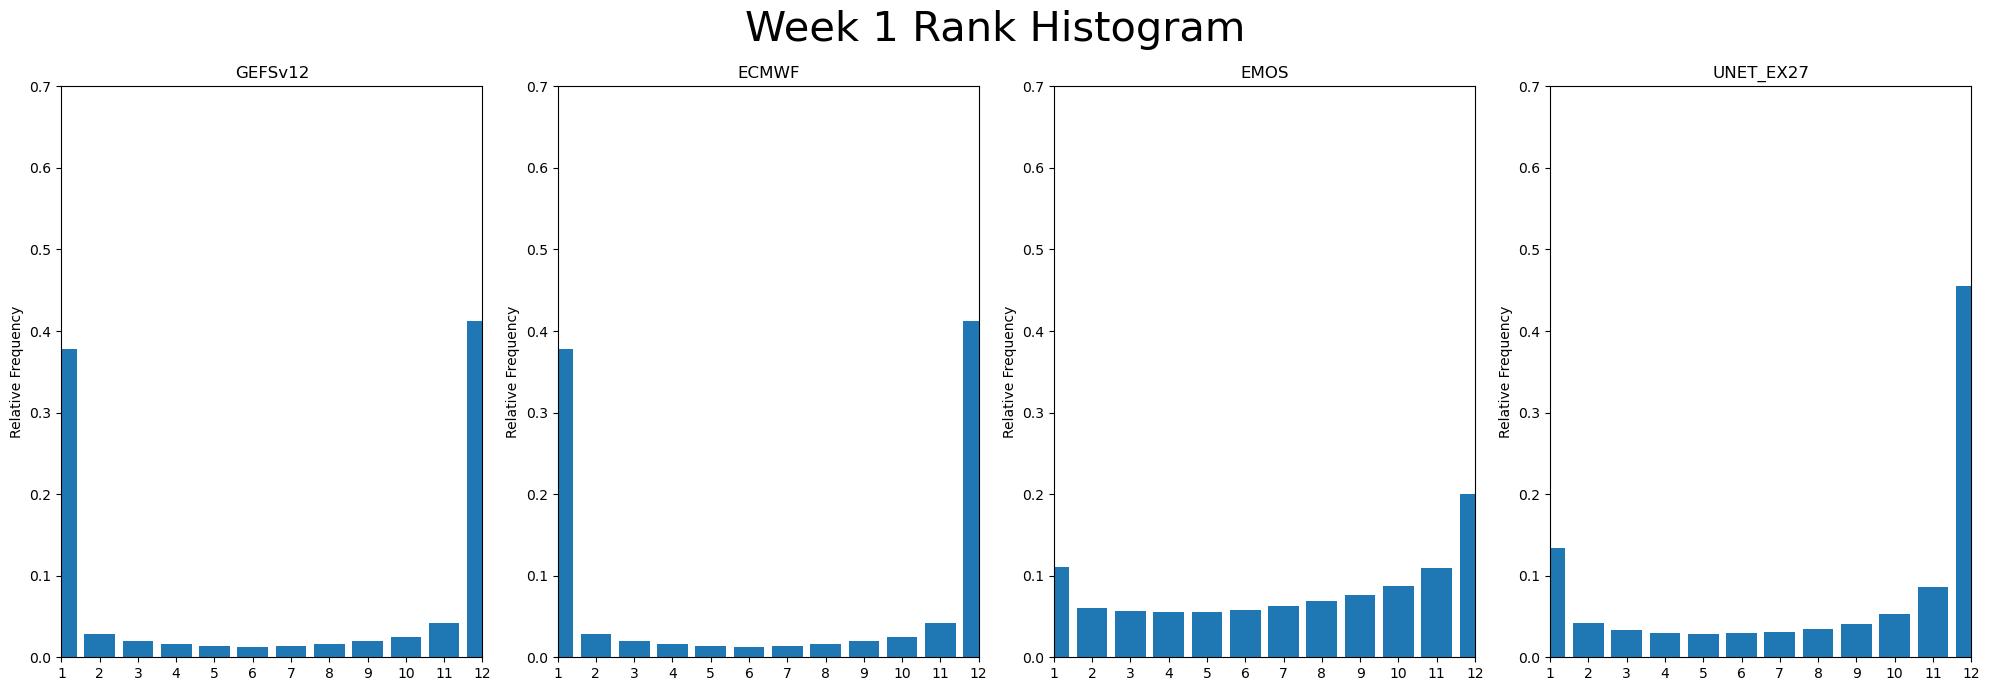

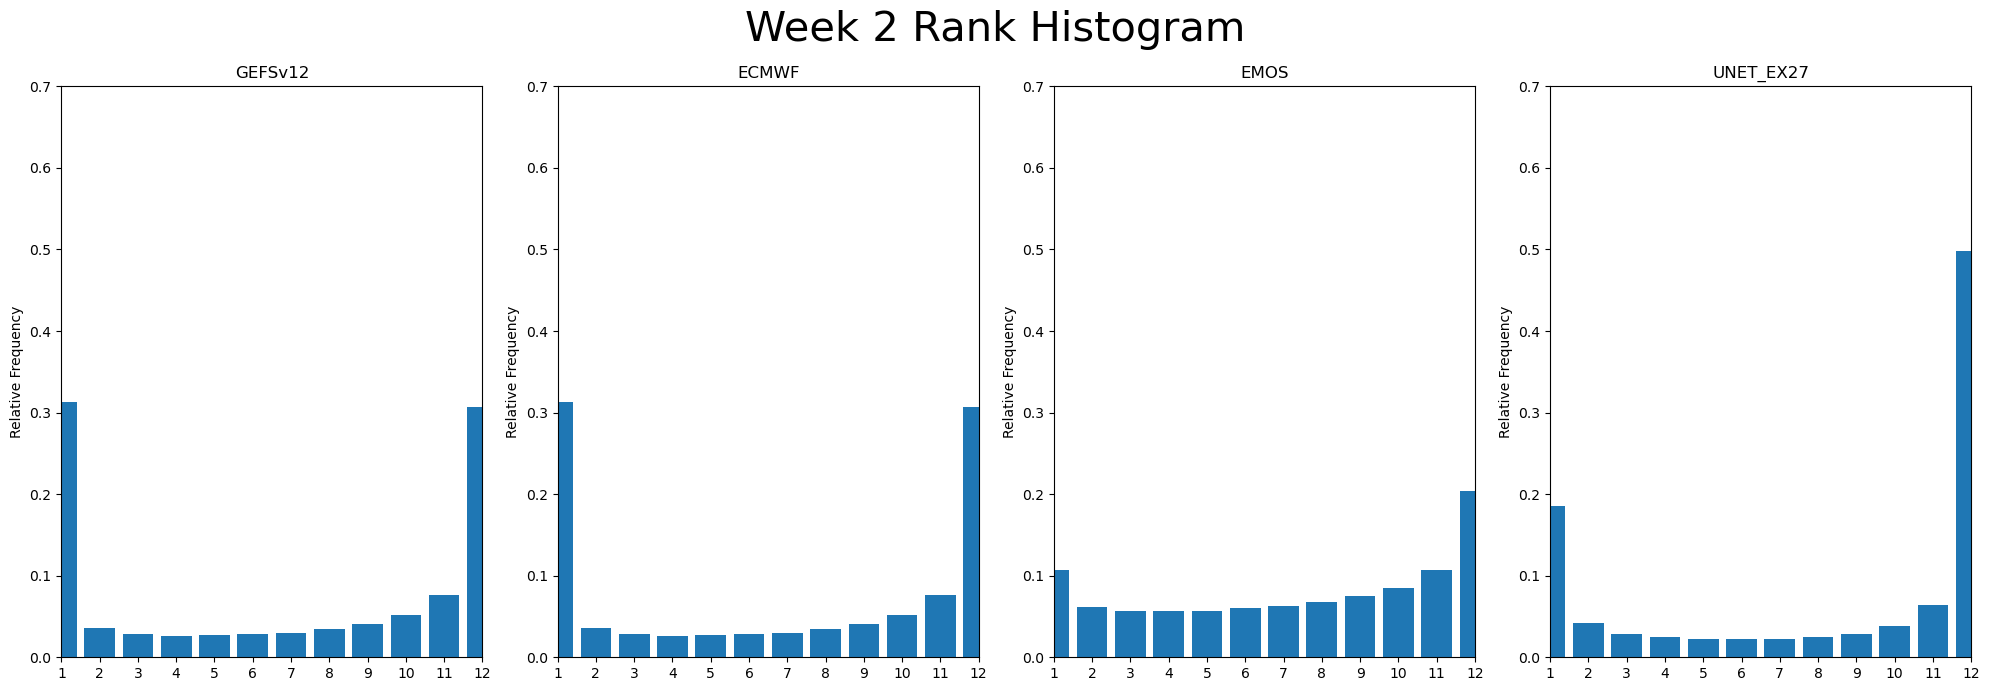

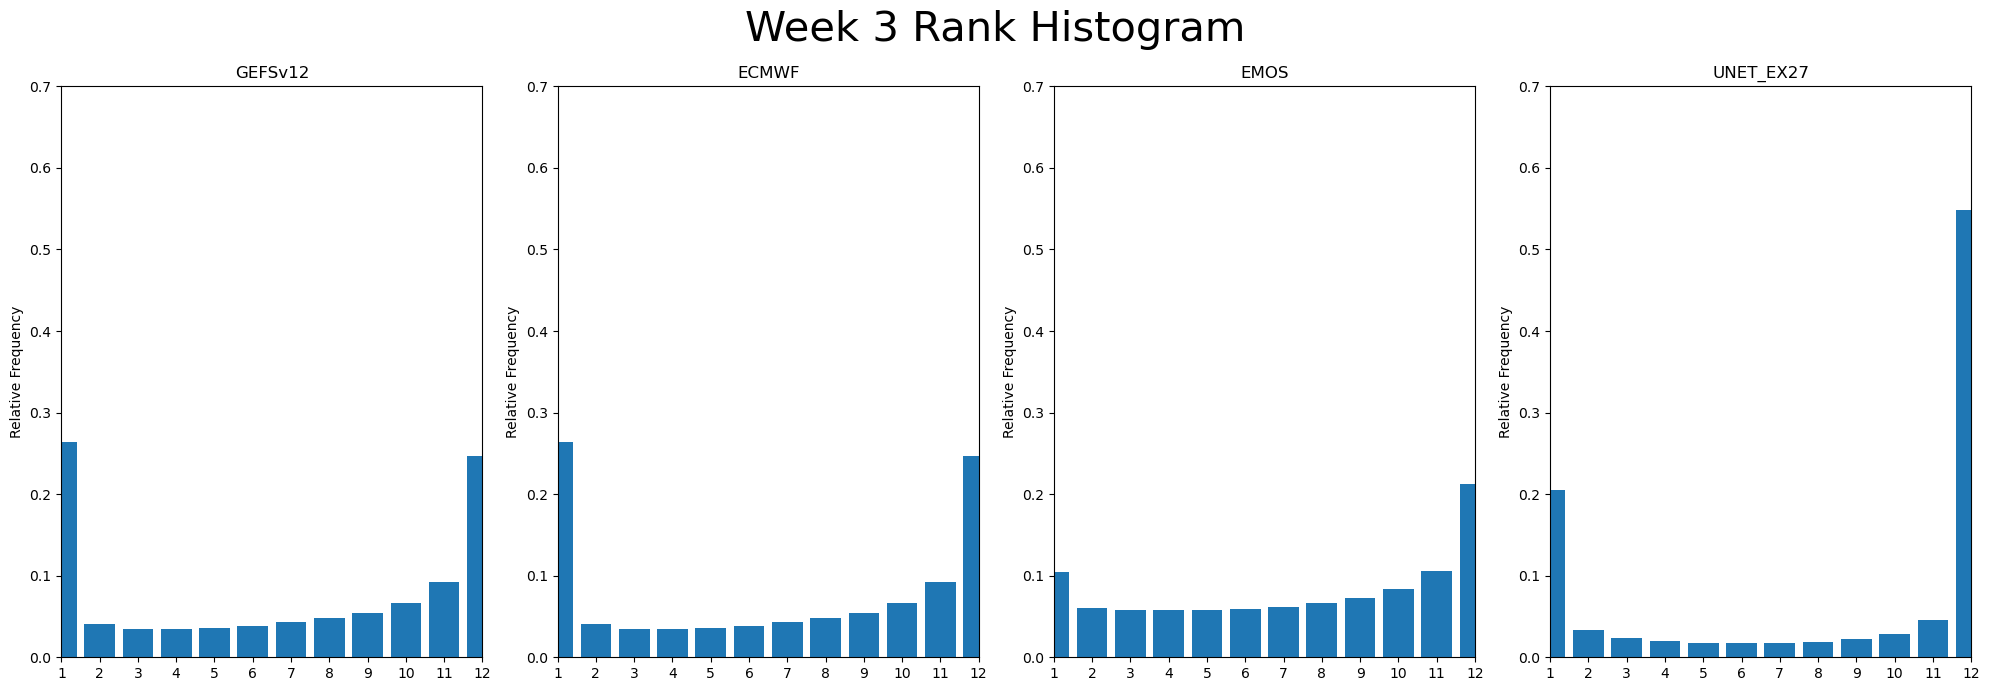

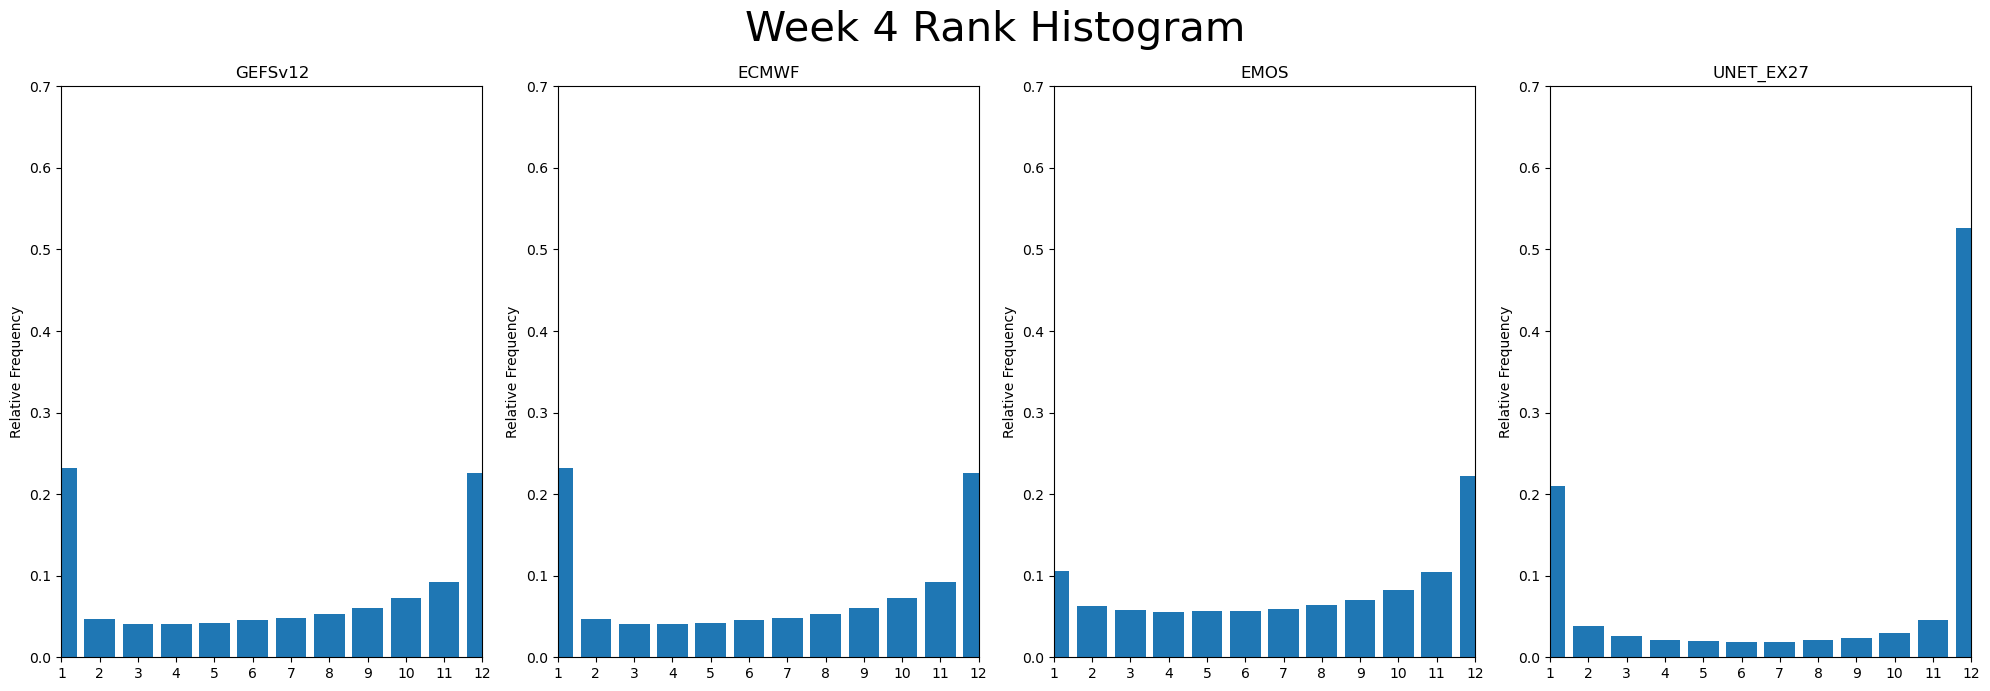

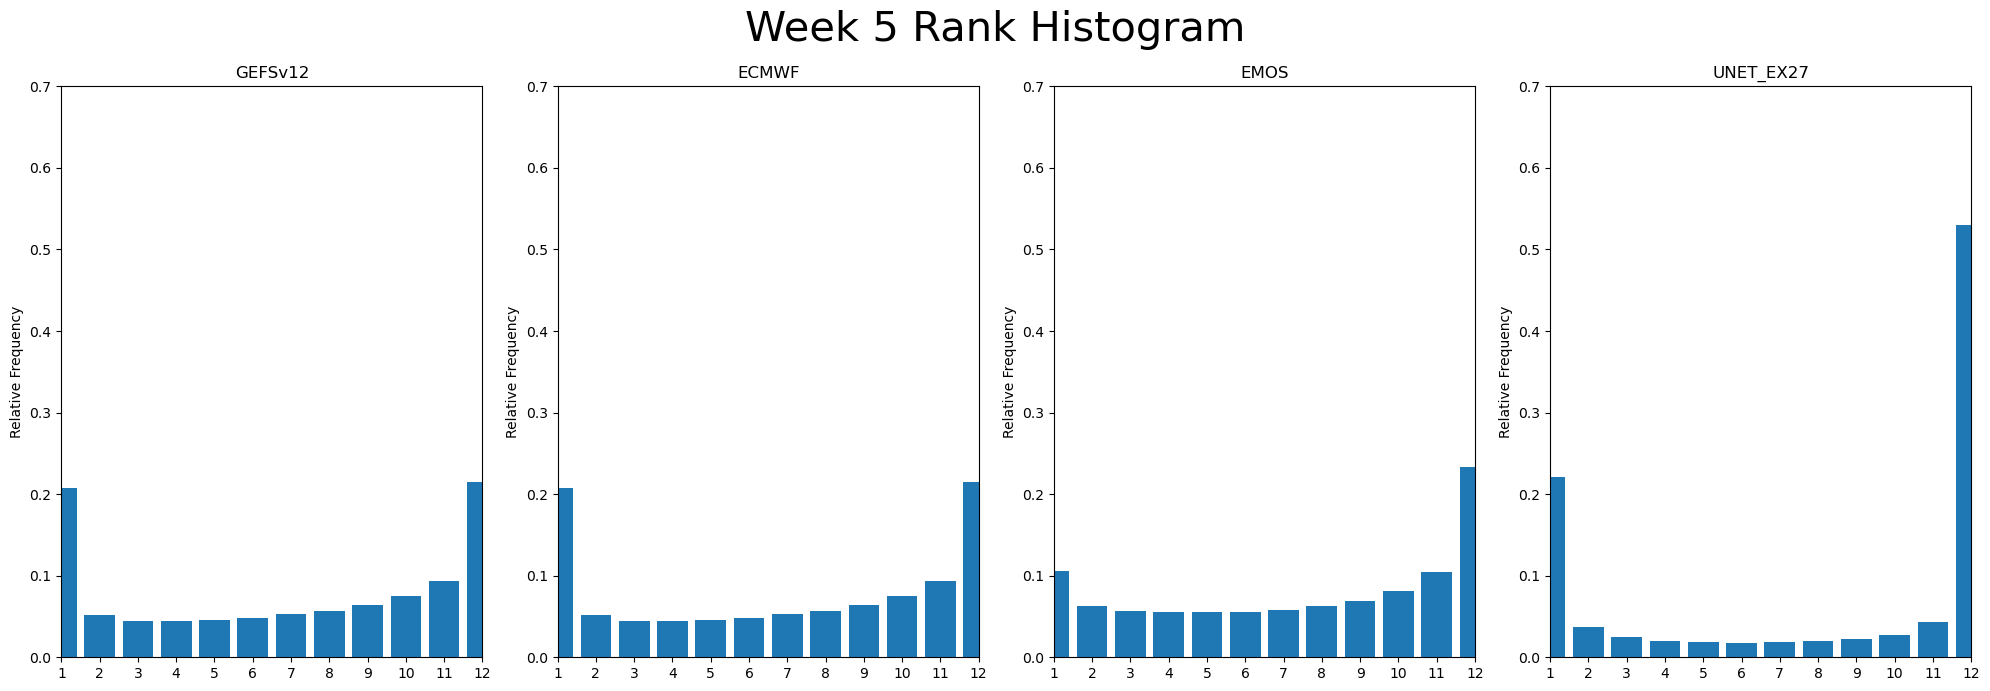

In [368]:
for week_lead in [1,2,3,4,5]:
    # ridgeplot_ACC_climpred(week_lead, region_name, test_start, test_end)
    # ridgeplot_CRPS(week_lead, region_name, test_start, test_end)
    # ridgeplot_standard_deviation(week_lead, region_name, test_start, test_end)
    # find_percentage_of_forecasts_that_contain_the_observation(week_lead, region_name, test_start, test_end)
    # ridgeplot_crpss_climpred(week_lead, region_name, test_start, test_end)
    # ridgeplot_crpss_ensemble_spread_climpred(week_lead, region_name, test_start, test_end)
    rank_histogram(week_lead, region_name, test_start, test_end)